## MOC3D Problem 2

This problem corresponds to the second problem presented in the MOC3D report
Konikow 1996, which involves the transport of a dissolved constituent in a
steady, three-dimensional flow field. An analytical solution for this problem
is given by Wexler 1992. This example is simulated with a GWT model, which
receives flow information from a separate GWF model. Results from the GWT
model are compared with results from the Wexler 1992 analytical solution.

### Initial setup

Import dependencies, define the example name and workspace, and read settings from environment variables.

In [1]:
import os
import pathlib as pl

import flopy
import git
import matplotlib.pyplot as plt
import numpy as np
from flopy.plot.styles import styles
from modflow_devtools.misc import get_env, timed
from scipy.special import erfc

# Example name and workspace paths. If this example is running
# in the git repository, use the folder structure described in
# the README. Otherwise just use the current working directory.
example_name = "ex-gwt-moc3d-p02"
try:
    root = pl.Path(git.Repo(".", search_parent_directories=True).working_dir)
except:
    root = None
workspace = root / "examples" if root else pl.Path.cwd()
figs_path = root / "figures" if root else pl.Path.cwd()

# Settings from environment variables
write = get_env("WRITE", True)
run = get_env("RUN", True)
plot = get_env("PLOT", True)
plot_show = get_env("PLOT_SHOW", True)
plot_save = get_env("PLOT_SAVE", True)

### Define parameters

Define model units, parameters and other settings.

In [2]:
# Model units
length_units = "meters"
time_units = "days"

# Model parameters
nper = 1  # Number of periods
nlay = 40  # Number of layers
nrow = 12  # Number of rows
ncol = 30  # Number of columns
delr = 3  # Column width ($m$)
delc = 0.5  # Row width ($m$)
delv = 0.05  # Layer thickness ($m$)
top = 0.0  # Top of the model ($m$)
bottom = -2.0  # Model bottom elevation ($m$)
velocity_x = 0.1  # Velocity in x-direction ($m d^{-1}$)
hydraulic_conductivity = 0.0125  # Hydraulic conductivity ($m d^{-1}$)
porosity = 0.25  # Porosity of mobile domain (unitless)
alpha_l = 0.6  # Longitudinal dispersivity ($m$)
alpha_th = 0.03  # Transverse horizontal dispersivity ($m$)
alpha_tv = 0.006  # Transverse vertical dispersivity ($m$)
total_time = 400.0  # Simulation time ($d$)
solute_mass_flux = 2.5  # Solute mass flux ($g d^{-1}$)
source_location = (1, 12, 8)  # Source location (layer, row, column)

botm = [-(k + 1) * delv for k in range(nlay)]
specific_discharge = velocity_x * porosity
source_location0 = tuple([idx - 1 for idx in source_location])

### Model setup

Define functions to build models, write input files, and run the simulation.

In [3]:
class Wexler3d:
    """
    Analytical solution for 3D transport with inflow at a well with a
    specified concentration.
    Wexler Page 47
    """

    def calcgamma(self, x, y, z, xc, yc, zc, dx, dy, dz):
        gam = np.sqrt((x - xc) ** 2 + dx / dy * (y - yc) ** 2 + dx / dz * (z - zc) ** 2)
        return gam

    def calcbeta(self, v, dx, gam, lam):
        beta = np.sqrt(v**2 + 4.0 * dx * gam * lam)
        return beta

    def analytical(self, x, y, z, t, v, xc, yc, zc, dx, dy, dz, n, q, lam=0.0, c0=1.0):
        gam = self.calcgamma(x, y, z, xc, yc, zc, dx, dy, dz)
        beta = self.calcbeta(v, dx, gam, lam)
        term1 = (
            c0
            * q
            * np.exp(v * (x - xc) / 2.0 / dx)
            / 8.0
            / n
            / np.pi
            / gam
            / np.sqrt(dy * dz)
        )
        term2 = np.exp(gam * beta / 2.0 / dx) * erfc(
            (gam + beta * t) / 2.0 / np.sqrt(dx * t)
        )
        term3 = np.exp(-gam * beta / 2.0 / dx) * erfc(
            (gam - beta * t) / 2.0 / np.sqrt(dx * t)
        )
        return term1 * (term2 + term3)

    def multiwell(self, x, y, z, t, v, xc, yc, zc, dx, dy, dz, n, ql, lam=0.0, c0=1.0):
        shape = self.analytical(
            x, y, z, t, v, xc[0], yc[0], zc[0], dx, dy, dz, n, ql[0], lam
        ).shape
        result = np.zeros(shape)
        for xx, yy, zz, q in zip(xc, yc, zc, ql):
            result += self.analytical(
                x, y, z, t, v, xx, yy, zz, dx, dy, dz, n, q, lam, c0
            )
        return result


def build_mf6gwf(sim_folder):
    print(f"Building mf6gwf model...{sim_folder}")
    name = "flow"
    sim_ws = os.path.join(workspace, sim_folder, "mf6gwf")
    sim = flopy.mf6.MFSimulation(sim_name=name, sim_ws=sim_ws, exe_name="mf6")
    tdis_ds = ((total_time, 1, 1.0),)
    flopy.mf6.ModflowTdis(sim, nper=nper, perioddata=tdis_ds, time_units=time_units)
    flopy.mf6.ModflowIms(sim, print_option="summary", inner_maximum=300)
    gwf = flopy.mf6.ModflowGwf(sim, modelname=name, save_flows=True)
    flopy.mf6.ModflowGwfdis(
        gwf,
        length_units=length_units,
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        delr=delr,
        delc=delc,
        top=top,
        botm=botm,
    )
    flopy.mf6.ModflowGwfnpf(
        gwf,
        save_specific_discharge=True,
        save_saturation=True,
        icelltype=0,
        k=hydraulic_conductivity,
    )
    flopy.mf6.ModflowGwfic(gwf, strt=0.0)
    chdspd = []
    welspd = []
    for k in range(nlay):
        for i in range(nrow):
            rec = [(k, i, ncol - 1), 0.0]
            chdspd.append(rec)
            rec = [(k, i, 0), specific_discharge * delc * delv]
            welspd.append(rec)
    flopy.mf6.ModflowGwfchd(gwf, stress_period_data=chdspd)
    flopy.mf6.ModflowGwfwel(gwf, stress_period_data=welspd)
    head_filerecord = f"{name}.hds"
    budget_filerecord = f"{name}.bud"
    flopy.mf6.ModflowGwfoc(
        gwf,
        head_filerecord=head_filerecord,
        budget_filerecord=budget_filerecord,
        saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],
    )
    return sim


def build_mf6gwt(sim_folder):
    print(f"Building mf6gwt model...{sim_folder}")
    name = "trans"
    sim_ws = os.path.join(workspace, sim_folder, "mf6gwt")
    sim = flopy.mf6.MFSimulation(sim_name=name, sim_ws=sim_ws, exe_name="mf6")
    tdis_ds = ((total_time, 400, 1.0),)
    flopy.mf6.ModflowTdis(sim, nper=nper, perioddata=tdis_ds, time_units=time_units)
    flopy.mf6.ModflowIms(sim, linear_acceleration="bicgstab")
    gwt = flopy.mf6.ModflowGwt(sim, modelname=name, save_flows=True)
    flopy.mf6.ModflowGwtdis(
        gwt,
        length_units=length_units,
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        delr=delr,
        delc=delc,
        top=top,
        botm=botm,
    )
    flopy.mf6.ModflowGwtic(gwt, strt=0)
    flopy.mf6.ModflowGwtmst(gwt, porosity=porosity)
    flopy.mf6.ModflowGwtadv(gwt, scheme="TVD")
    flopy.mf6.ModflowGwtdsp(
        gwt,
        xt3d_off=True,
        alh=alpha_l,
        ath1=alpha_th,
        ath2=alpha_tv,
    )
    pd = [
        ("GWFHEAD", "../mf6gwf/flow.hds", None),
        ("GWFBUDGET", "../mf6gwf/flow.bud", None),
    ]
    flopy.mf6.ModflowGwtfmi(gwt, packagedata=pd)
    sourcerecarray = [[]]
    srcspd = [[source_location0, solute_mass_flux]]
    flopy.mf6.ModflowGwtsrc(gwt, stress_period_data=srcspd)
    flopy.mf6.ModflowGwtssm(gwt, sources=sourcerecarray)
    obs_data = {
        f"{name}.obs.csv": [
            ("SOURCELOC", "CONCENTRATION", source_location0),
        ],
    }
    obs_package = flopy.mf6.ModflowUtlobs(
        gwt, digits=10, print_input=True, continuous=obs_data
    )
    flopy.mf6.ModflowGwtoc(
        gwt,
        budget_filerecord=f"{name}.cbc",
        concentration_filerecord=f"{name}.ucn",
        saverecord=[("CONCENTRATION", "ALL"), ("BUDGET", "LAST")],
        printrecord=[("CONCENTRATION", "LAST"), ("BUDGET", "LAST")],
    )
    return sim


def build_models(sim_name):
    return build_mf6gwf(sim_name), build_mf6gwt(sim_name)


def write_models(sims, silent=True):
    for sim in sims:
        sim.write_simulation(silent=silent)


@timed
def run_models(sims, silent=True):
    for sim in sims:
        success, buff = sim.run_simulation(silent=silent)
        assert success, buff

### Plotting results

Define functions to plot model results.

In [4]:
# Figure properties
figure_size = (6, 4)


def plot_analytical(ax, levels):
    n = porosity
    v = velocity_x
    al = alpha_l
    ath = alpha_th
    atv = alpha_tv
    c0 = 10.0
    xc = [22.5]
    yc = [0]
    zc = [0]
    q = [1.0]
    dx = v * al
    dy = v * ath
    dz = v * atv
    lam = 0.0
    x = np.arange(0 + delr / 2.0, ncol * delr + delr / 2.0, delr)
    y = np.arange(0 + delc / 2.0, nrow * delc + delc / 2.0, delc)
    x, y = np.meshgrid(x, y)
    z = 0
    t = 400.0
    c400 = Wexler3d().multiwell(x, y, z, t, v, xc, yc, zc, dx, dy, dz, n, q, lam, c0)
    cs = ax.contour(x, y, c400, levels=levels, colors="k")
    return cs


def plot_results(sims):
    _, sim_mf6gwt = sims
    with styles.USGSMap():
        conc = sim_mf6gwt.trans.output.concentration().get_data()
        fig, axs = plt.subplots(1, 1, figsize=figure_size, dpi=300, tight_layout=True)
        gwt = sim_mf6gwt.trans
        pmv = flopy.plot.PlotMapView(model=gwt, ax=axs)
        levels = [1, 3, 10, 30, 100, 300]
        cs1 = plot_analytical(axs, levels)
        cs2 = pmv.contour_array(conc, colors="blue", linestyles="--", levels=levels)
        axs.set_xlabel("x position (m)")
        axs.set_ylabel("y position (m)")
        axs.set_aspect(4.0)

        labels = ["Analytical", "MODFLOW 6"]
        lines = [cs1.collections[0], cs2.collections[0]]
        axs.legend(lines, labels, loc="upper left")

        if plot_show:
            plt.show()
        if plot_save:
            sim_ws = sim_mf6gwt.simulation_data.mfpath.get_sim_path()
            sim_folder = os.path.split(sim_ws)[0]
            sim_folder = os.path.basename(sim_folder)
            fname = f"{sim_folder}-map.png"
            fpth = figs_path / fname
            fig.savefig(fpth)

### Running the example

Define and invoke a function to run the example scenario, then plot results.

Building mf6gwf model...ex-gwt-moc3d-p02
Building mf6gwt model...ex-gwt-moc3d-p02


run_models took 8938.31 ms


/tmp/ipykernel_13742/2338721584.py:45: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  lines = [cs1.collections[0], cs2.collections[0]]
/tmp/ipykernel_13742/2338721584.py:45: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  lines = [cs1.collections[0], cs2.collections[0]]


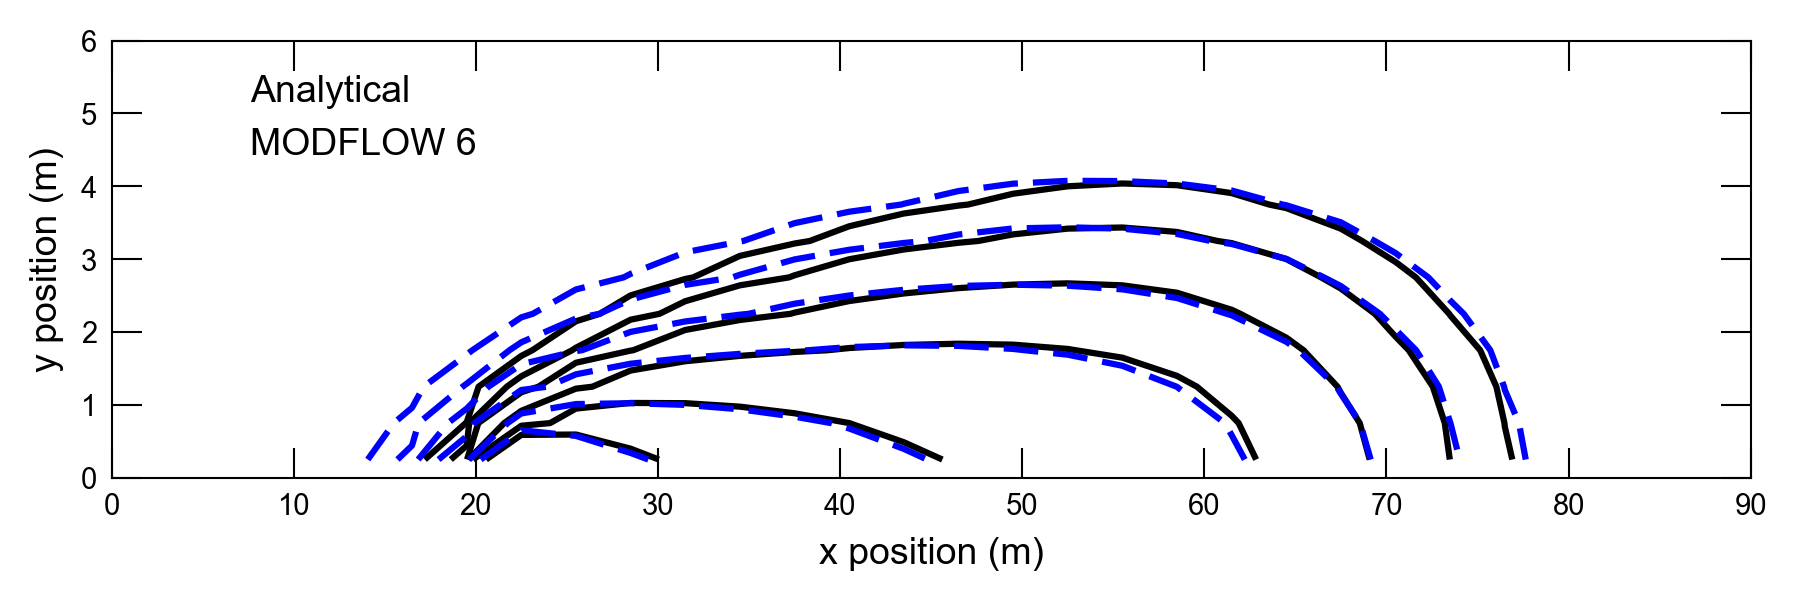

In [5]:
def scenario(silent=True):
    sims = build_models(example_name)
    if write:
        write_models(sims, silent=silent)
    if run:
        run_models(sims, silent=silent)
    if plot:
        plot_results(sims)


scenario()